### Reference materials


Cumulative Distribution Function - distribution function of X, evaluated at x, is the probability that 
X will take a value less than or equal to x

For samples of population an Empirical Cumulative Distribution Function can be used with confidence intervals from Dvoretzky-Kiefer-Wolfowitz (DKW) inequality.

https://james-brennan.github.io/posts/edf/

https://en.wikipedia.org/wiki/Dvoretzky–Kiefer–Wolfowitz_inequality


### Imports

In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sci_analysis import analyze
from statsmodels.distributions.empirical_distribution import ECDF
# %matplotlib inline


### Constants and variables

In [2]:
SEED = 42
RESET_SEED = True
np.random.seed(SEED)

# VARIABLES ----------------------------------------
DATA_DIR = '../data/ComCom_Adam/'
DATA_TEST_DIR = '../data/ComCom_Adam/scaler_000/'
DATA_TEST_FILE_PREFIX = '000_'
# setup time files
TIMES = [15, 60, 120, 180, 240, 360, 480, 720, 1440]
# model: before|after
MODELS = ['after', 'before']
# bins
TRAFFIC_BINS = [i * 500 for i in range(21)]
# how much overhead to meet required confidence based on eCDF
CONFIDENCE = [0.9, 0.95, 0.97]

# CONSTANTS ----------------------------------------
DATA_REAL_NAME = 'real'
DATA_BEFORE_NAME = 'before'
DATA_AFTER_NAME = 'after'

RESULTS_DIR = '../results/'
RESULT_SINGLE_FILE_NAME = 'single.csv'
RESULT_BINS_FILE_NAME = 'bins.csv'


### Functions

In [3]:
def init_random():
    np.random.seed(SEED)
    

def perc_underestimated_traffic(df_real, df_pred):
    under_recs = ((df_pred - df_real) < 0).astype(int).sum().sum()
    all_recs = df_pred.size
    return under_recs / all_recs * 100


def get_distributions(df, bins=1000, alpha=0.05, plot=True):
    '''
    get pdf, cdf and ecdf
    
    returns pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins
    '''

    pdf, bins = np.histogram(df, bins=bins)

    # cumulative distribution normalized to 0:1
    cdf = np.cumsum(pdf.data)
    cdf = cdf / cdf[-1] 
    
    # calculating ecdf and its lower/upper bounds
    _ecdf = ECDF(df)
    ecdf = np.array([_ecdf.y, _ecdf.x])
    
    # Dvoretzky–Kiefer–Wolfowitz confidence bounds
    epsilon = np.sqrt(1/(2*len(ecdf[1])) * np.log(2./alpha))
    ecdf_upper = np.minimum(ecdf[0] + epsilon, 1)
    ecdf_lower = np.maximum(ecdf[0] - epsilon, 0)
    
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(8, 3))
        _ = ax[0].hist(bins[:-1], bins, weights=pdf)
        _ = ax[0].set_title("PDF")
        
        _ = ax[1].hist(bins[:-1], bins, weights=cdf)
        _ = ax[1].set_title("CDF")
        
        _ = ax[2].plot(ecdf[1], ecdf[0], '-')
        _ = ax[2].fill_between(ecdf[1], ecdf_upper, ecdf_lower, color='y')
        _ = ax[2].set_title("eCDF")
        sns.despine()

    return np.array([pdf, bins[:-1]]), np.array([cdf, bins[:-1]]), \
           ecdf, np.array([ecdf_lower, _ecdf.x]), np.array([ecdf_upper, _ecdf.x]), bins


def get_x_for_y(yx_data, y):
    '''
        Find x value matching given y value using linear approximation
        
        return: x, y, x_l, x_r, y_l, y_r
    '''
    
    # finding first index above condition
    idx = np.where(yx_data[0] >= y)  

    idx = idx[0][0] if len(idx[0]) > 0 else len(yx_data[0]) - 1
    x_r = yx_data[1][idx]
    y_r = yx_data[0][idx]
    
    if idx > 0:
        x_l = yx_data[1][idx - 1]
        y_l = yx_data[0][idx - 1]
        # from line segment: (1 - lambd) y_l + lambd * y_r = y
        lambd = (y - y_l) / (y_r - y_l) 
        x = (1 - lambd) * x_l + lambd * x_r
    else:
        x = x_r
        x_l = x_r
        y_l = y
        
    return x, y, x_l, x_r, y_l, y_r

# Execution

In [4]:
# load files

dfs_real = []
dfs_pred = []

dfs_real_test = []
dfs_pred_test = []

for model in MODELS:
    # train data
    dfs_real_inner = []
    dfs_pred_inner = []
    for time in TIMES:
        dfs_real_inner.append(pd.read_csv(DATA_DIR + DATA_REAL_NAME + str(time) + '.csv', sep='\t', header=None))
        if model == 'after':
            dfs_pred_inner.append(pd.read_csv(DATA_DIR + DATA_AFTER_NAME + str(time) + '.csv', sep='\t', header=None))
        elif model == 'before':
            dfs_pred_inner.append(pd.read_csv(DATA_DIR + DATA_BEFORE_NAME + str(time) + '.csv', sep='\t', header=None))
    dfs_real.append(dfs_real_inner)
    dfs_pred.append(dfs_pred_inner)
    
    # test data
    dfs_real_test_inner = []
    dfs_pred_test_inner = []
    for time in TIMES:
        dfs_real_test_inner.append(pd.read_csv(DATA_TEST_DIR + DATA_TEST_FILE_PREFIX + DATA_REAL_NAME + str(time) + '.csv', sep='\t', header=None))
        if model == 'after':
            dfs_pred_test_inner.append(pd.read_csv(DATA_TEST_DIR + DATA_TEST_FILE_PREFIX + DATA_AFTER_NAME + str(time) + '.csv', sep='\t', header=None))
        elif model == 'before':
            dfs_pred_test_inner.append(pd.read_csv(DATA_TEST_DIR + DATA_TEST_FILE_PREFIX + DATA_BEFORE_NAME + str(time) + '.csv', sep='\t', header=None))
    dfs_real_test.append(dfs_real_test_inner)
    dfs_pred_test.append(dfs_pred_test_inner)
        
    

## Case 1: Treat all values from models for various node pairs as single distribution

In [5]:
# result describing how much add abs_value or percentage for given period/model having confidence that <conf>
# predictions are not underestimated

# abs_value - how much add absolute value
# abs_wo_approx - linear approximation may go outside the right boundary
# percentage - homu much percenta add to value 
# percentage_wo_appox - linear approximation may go outside the right boundary

col_names = ['model', 'period', 'conf', 'abs_value', 'abs_wo_approx', 'percentage', 'percentage_wo_approx']
df_result = pd.DataFrame(columns=col_names)

for m_idx, model in enumerate(MODELS):
    for t_idx, time in enumerate(TIMES):
        
        real = dfs_real[m_idx][t_idx]
        pred = dfs_pred[m_idx][t_idx]
    
        real_stk = real.stack().reset_index(drop=True)
        pred_stk = pred.stack().reset_index(drop=True)
        diff = (real_stk - pred_stk)
        perc = (real_stk - pred_stk) / pred_stk * 100 
#         perc_half = perc[perc > 0].reset_index(drop=True)
        
        res = [{'model' : model, 'period' : time, 'conf': conf} for conf in CONFIDENCE]
        
        pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=diff, plot=False)
        
        for conf_idx, conf in enumerate(CONFIDENCE):
            x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=conf) 
            res_d = res[conf_idx]
            res_d['abs_value'] = x 
            res_d['abs_wo_approx'] = x_r
                
        
        pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=perc, plot=False)
            
        for conf_idx, conf in enumerate(CONFIDENCE):
            x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=conf) 
            res_d = res[conf_idx]
            res_d['percentage'] = x
            res_d['percentage_wo_approx'] = x_r
            
        df_result = pd.concat([df_result, pd.DataFrame(data=res, columns=col_names)], axis=0, ignore_index=True)
        
df_result = df_result.reset_index(drop=True)

In [6]:
display(df_result)
df_result.to_csv(RESULTS_DIR + RESULT_SINGLE_FILE_NAME)

,model,period,conf,abs_value,abs_wo_approx,percentage,percentage_wo_approx
0,after,15,0.90,176.000000,176.000000,16.427288,16.427784
1,after,15,0.95,230.000000,230.000000,21.073646,21.074816
2,after,15,0.97,275.000000,275.000000,24.675325,24.675325
3,after,60,0.90,202.000000,202.000000,18.133728,18.134715
4,after,60,0.95,261.000000,261.000000,22.727273,22.727273
5,after,60,0.97,311.000000,311.000000,26.241349,26.251277
6,after,120,0.90,216.000000,216.000000,18.954059,18.957346
7,after,120,0.95,274.000000,274.000000,23.544726,23.549884
8,after,120,0.97,329.188030,330.000000,27.658946,27.698574
9,after,180,0.90,233.809315,234.000000,19.111305,19.112628


### Validate

In [7]:
col_names = ['model', 'period', 'conf', 'underestimate', 'corr_abs', 'corr_perc', 'abs_success', 'perc_success']

df_validate_train = pd.DataFrame(columns=col_names)
df_validate_test = pd.DataFrame(columns=col_names)

for m_idx, model in enumerate(MODELS):
    for t_idx, time in enumerate(TIMES):
        train_real = dfs_real[m_idx][t_idx]
        train_pred = dfs_pred[m_idx][t_idx]
        
        test_real = dfs_real_test[m_idx][t_idx]
        test_pred = dfs_pred_test[m_idx][t_idx]
        
        for conf in CONFIDENCE:
            
            sel = df_result[(df_result['model'] == model) & (df_result['period'] == time)  & (df_result['conf'] == conf)]
            
            abs_ov = sel['abs_wo_approx'].values[0]
            perc_ov = sel['percentage_wo_approx'].values[0] / 100
            
            # validate train 
            
            train_pred_abs_ov = train_pred + abs_ov 
            train_pred_perc_ov = train_pred + train_pred * perc_ov
            
            p = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred)
            p_abs = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred_abs_ov)
            p_perc = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred_perc_ov)
            
            abs_success = (1 - conf) * 100 >= p_abs
            perc_success = (1 - conf) * 100 >= p_perc
            
            res = {'model' : model, 
                   'period' : time, 
                   'conf': conf,
                   'underestimate': p,
                   'corr_abs': p_abs,
                   'corr_perc': p_perc,
                   'abs_success': abs_success, 
                   'perc_success': perc_success,
                  } 
            df_validate_train = pd.concat([df_validate_train, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)

            # validate test
            test_pred_abs_ov = test_pred + abs_ov 
            test_pred_perc_ov = test_pred + train_pred * perc_ov
            
            p = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred)
            p_abs = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred_abs_ov)
            p_perc = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred_perc_ov)
            
            abs_success = (1 - conf) * 100 >= p_abs
            perc_success = (1 - conf) * 100 >= p_perc
            
            res = {'model' : model, 
                   'period' : time, 
                   'conf': conf,
                   'underestimate': p,
                   'corr_abs': p_abs,
                   'corr_perc': p_perc,
                   'abs_success': abs_success, 
                   'perc_success': perc_success,
                  } 
            df_validate_test = pd.concat([df_validate_test, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display("train table")
    display(df_validate_train)
    display("test table")
    display(df_validate_test)

'train table'

,model,period,conf,underestimate,corr_abs,corr_perc,abs_success,perc_success
0,after,15,0.90,64.575066,9.408069,9.494874,True,True
1,after,15,0.95,64.575066,4.484954,4.494599,True,True
2,after,15,0.97,64.575066,2.473269,2.495315,True,True
3,after,60,0.90,79.144621,8.956129,8.989198,True,True
4,after,60,0.95,79.144621,3.990300,3.979277,True,True
5,after,60,0.97,79.144621,1.978616,1.989638,True,True
6,after,120,0.90,85.339506,8.509700,8.564815,True,True
7,after,120,0.95,85.339506,3.505291,3.571429,True,True
8,after,120,0.97,85.339506,1.521164,1.565256,True,True
9,after,180,0.90,89.203042,8.167989,8.250661,True,True


'test table'

,model,period,conf,underestimate,corr_abs,corr_perc,abs_success,perc_success
0,after,15,0.90,64.581955,12.967097,10.187941,False,False
1,after,15,0.95,64.581955,6.989914,4.544202,False,True
2,after,15,0.97,64.581955,4.263117,2.346506,False,True
3,after,60,0.90,77.645503,12.874780,9.865520,False,True
4,after,60,0.95,77.645503,6.492504,3.973765,False,True
5,after,60,0.97,77.645503,3.692681,1.984127,False,True
6,after,120,0.90,84.380511,13.436949,9.788360,False,True
7,after,120,0.95,84.380511,6.856261,3.968254,False,True
8,after,120,0.97,84.380511,3.769841,1.642416,False,True
9,after,180,0.90,84.672619,11.904762,9.871032,False,True


In [9]:
train_count = df_validate_train['abs_success'].shape[0]
train_abs_suc = df_validate_train['abs_success'].astype(int).sum()    
train_perc_suc = df_validate_train['perc_success'].astype(int).sum()    

test_count = df_validate_test['abs_success'].shape[0]
test_abs_suc = df_validate_test['abs_success'].astype(int).sum()    
test_perc_suc = df_validate_test['perc_success'].astype(int).sum()    

display('train abs: ' + str(train_abs_suc) + "/" + str(train_count) + " -> " + str(train_abs_suc / train_count * 100))
display('train perc: ' + str(train_perc_suc) + "/" + str(train_count) + " -> " + str(train_perc_suc / train_count * 100))
display('test abs: ' + str(test_abs_suc) + "/" + str(test_count) + " -> " + str(test_abs_suc / test_count * 100))
display('test perc: ' + str(test_perc_suc) + "/" + str(test_count) + " -> " + str(test_perc_suc / test_count * 100))

'train abs: 54/54 -> 100.0'

'train perc: 54/54 -> 100.0'

'test abs: 26/54 -> 48.148148148148145'

'test perc: 47/54 -> 87.03703703703704'

## Case 2: cut to bins

In [10]:
# result describing how much add abs_value or percentage for given period/model having confidence that <conf>
# predictions are not underestimated

# abs_value - how much add absolute value
# abs_wo_approx - linear approximation may go outside the right boundary
# percentage - homu much percenta add to value 
# percentage_wo_appox - linear approximation may go outside the right boundary

col_names = ['model', 'period', 'conf', 'bitrate_start_incl', 'bitrate_end_excl', 'abs_value', 'abs_wo_approx', 'percentage', 'percentage_wo_approx']
df_result = pd.DataFrame(columns=col_names)

for m_idx, model in enumerate(MODELS):
    for t_idx, time in enumerate(TIMES):
        
        real = dfs_real[m_idx][t_idx]
        pred = dfs_pred[m_idx][t_idx]
    
        real_stk = real.stack().reset_index(drop=True)
        pred_stk = pred.stack().reset_index(drop=True)
        
        res_binned = []
        for idx, bin_start in enumerate(TRAFFIC_BINS[:-1]):
            bin_end = TRAFFIC_BINS[idx + 1]

            real_bin = real_stk[(real_stk >= bin_start) & (real_stk < bin_end)]
            pred_bin = pred_stk.iloc[real_bin.index]
            
            diff = (real_bin - pred_bin)
            perc = (real_bin - pred_bin) / pred_bin * 100 
            

            res = [{'model' : model, 'period' : time, 'conf': conf,
                    'bitrate_start_incl': bin_start,
                    'bitrate_end_excl': bin_end,
                   } for conf in CONFIDENCE]

            # skip empty and singular bins
            if real_bin.shape[0] > 1:
                res = [{'model' : model, 'period' : time, 'conf': conf,
                        'bitrate_start_incl': bin_start,
                        'bitrate_end_excl': bin_end,
                       } for conf in CONFIDENCE]

                pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=diff, plot=False)
            
                for conf_idx, conf in enumerate(CONFIDENCE):
                    x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=conf) 
                    res_d = res[conf_idx]
                    res_d['abs_value'] = x 
                    res_d['abs_wo_approx'] = x_r
                
                pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=perc, plot=False)

                for conf_idx, conf in enumerate(CONFIDENCE):
                    x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=conf) 
                    res_d = res[conf_idx]
                    res_d['percentage'] = x
                    res_d['percentage_wo_approx'] = x_r
    
            res_binned.extend(res)
        
        df_binned = pd.DataFrame(data=res_binned, columns=col_names)
               
        # if some bins skipped due to the missing values
        # replace with the closest ones (from bottom first, then from top)
        # thus, first group then apply fill on groups

        grouped = df_binned.groupby('conf', group_keys=False)
        df_binned['abs_value'] = grouped['abs_value'].apply(lambda s: s.bfill().ffill())
        df_binned['abs_wo_approx'] = grouped['abs_wo_approx'].apply(lambda s: s.bfill().ffill())
        df_binned['percentage'] = grouped['percentage'].apply(lambda s: s.bfill().ffill())
        df_binned['percentage_wo_approx'] = grouped['percentage_wo_approx'].apply(lambda s: s.bfill().ffill())

        df_result = pd.concat([df_result, df_binned], axis=0, ignore_index=True)

df_result = df_result.reset_index(drop=True)

In [11]:
display(df_result)
df_result.to_csv(RESULTS_DIR + RESULT_BINS_FILE_NAME)

,model,period,conf,bitrate_start_incl,bitrate_end_excl,abs_value,abs_wo_approx,percentage,percentage_wo_approx
0,after,15,0.90,0,500,73.000000,73.000000,20.334672,20.343840
1,after,15,0.95,0,500,98.000000,98.000000,28.923498,28.947368
2,after,15,0.97,0,500,124.000000,124.000000,38.111480,38.192420
3,after,15,0.90,500,1000,124.000000,124.000000,19.153268,19.156415
4,after,15,0.95,500,1000,154.000000,154.000000,24.632353,24.632353
...,...,...,...,...,...,...,...,...,...
1075,before,1440,0.95,9000,9500,830.751096,325.871903,11.253459,4.356502
1076,before,1440,0.97,9000,9500,848.867857,325.871903,11.500945,4.356502
1077,before,1440,0.90,9500,10000,785.459196,325.871903,10.634744,4.356502
1078,before,1440,0.95,9500,10000,830.751096,325.871903,11.253459,4.356502


### Validate

In [12]:
def get_bin_start_value(bitrate):
    '''not used'''
    # numpy digitize can calssify value to bins
    bin_id = np.digitize(value, TRAFFIC_BINS[:-1]) - 1
    bin_start = TRAFFIC_BINS[bin_id]
    return bin_start
    

col_names = ['model', 'period', 'conf', 'underestimate', 'corr_abs', 'corr_perc', 'abs_success', 'perc_success']

df_validate_train = pd.DataFrame(columns=col_names)
df_validate_test = pd.DataFrame(columns=col_names)

for m_idx, model in enumerate(MODELS):
    for t_idx, time in enumerate(TIMES):
        train_real = dfs_real[m_idx][t_idx]
        train_pred = dfs_pred[m_idx][t_idx]
        
        test_real = dfs_real_test[m_idx][t_idx]
        test_pred = dfs_pred_test[m_idx][t_idx]
        
        for conf in CONFIDENCE:
            
            overheads = df_result[(df_result['model'] == model) & (df_result['period'] == time)  & (df_result['conf'] == conf)]
            
            abs_ovs = overheads['abs_wo_approx']
            perc_ovs = overheads['percentage_wo_approx'] / 100
            
            # validate train
            
            train_pred_abs_ov = train_pred
            train_pred_perc_ov = train_pred
            
            # update value in each bin in train
            for bin_idx, bin_start in enumerate(TRAFFIC_BINS[:-1]):
                bin_end = TRAFFIC_BINS[bin_idx + 1]
                
                # if not last
                if bin_end < TRAFFIC_BINS[-1]:
                    indices = (train_pred >= bin_start) & (train_pred < bin_end)
                else:
                    indices = (train_pred >= bin_start)
                
                
                abs_ov = abs_ovs[overheads['bitrate_start_incl'] == bin_start].values[0]
                perc_ov = perc_ovs[overheads['bitrate_start_incl'] == bin_start].values[0]

                train_pred_abs_ov[indices] = train_pred_abs_ov[indices] + abs_ov
                train_pred_perc_ov[indices] = train_pred_perc_ov[indices] * (1 + perc_ov)

            p = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred)
            p_abs = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred_abs_ov)
            p_perc = perc_underestimated_traffic(df_real=train_real, df_pred=train_pred_perc_ov)

            abs_success = (1 - conf) * 100 >= p_abs
            perc_success = (1 - conf) * 100 >= p_perc
            
            res = {'model' : model, 
                   'period' : time, 
                   'conf': conf,
                   'underestimate': p,
                   'corr_abs': p_abs,
                   'corr_perc': p_perc,
                   'abs_success': abs_success, 
                   'perc_success': perc_success,
                  } 
            df_validate_train = pd.concat([df_validate_train, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)

            
            # validate test
            test_pred_abs_ov = test_pred
            test_pred_perc_ov = test_pred
            
            # update value in each bin in train
            for bin_idx, bin_start in enumerate(TRAFFIC_BINS[:-1]):
                bin_end = TRAFFIC_BINS[bin_idx + 1]
                
                # if not last
                if bin_end < TRAFFIC_BINS[-1]:
                    indices = (test_pred >= bin_start) & (test_pred < bin_end)
                else:
                    indices = (test_pred >= bin_start)
                
                
                abs_ov = abs_ovs[overheads['bitrate_start_incl'] == bin_start].values[0]
                perc_ov = perc_ovs[overheads['bitrate_start_incl'] == bin_start].values[0]

                test_pred_abs_ov[indices] = test_pred_abs_ov[indices] + abs_ov
                test_pred_perc_ov[indices] = test_pred_perc_ov[indices] * (1 + perc_ov)

            p = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred)
            p_abs = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred_abs_ov)
            p_perc = perc_underestimated_traffic(df_real=test_real, df_pred=test_pred_perc_ov)

            abs_success = (1 - conf) * 100 >= p_abs
            perc_success = (1 - conf) * 100 >= p_perc
            
            res = {'model' : model, 
                   'period' : time, 
                   'conf': conf,
                   'underestimate': p,
                   'corr_abs': p_abs,
                   'corr_perc': p_perc,
                   'abs_success': abs_success, 
                   'perc_success': perc_success,
                  } 
            df_validate_test = pd.concat([df_validate_test, pd.DataFrame(res, index=[0])], axis=0, ignore_index=True)


In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display("train table")
    display(df_validate_train)
    display("test table")
    display(df_validate_test)

'train table'

,model,period,conf,underestimate,corr_abs,corr_perc,abs_success,perc_success
0,after,15,0.90,0.033069,0.033069,0.033069,True,True
1,after,15,0.95,0.000000,0.000000,0.000000,True,True
2,after,15,0.97,0.000000,0.000000,0.000000,True,True
3,after,60,0.90,0.000000,0.000000,0.000000,True,True
4,after,60,0.95,0.000000,0.000000,0.000000,True,True
5,after,60,0.97,0.000000,0.000000,0.000000,True,True
6,after,120,0.90,0.000000,0.000000,0.000000,True,True
7,after,120,0.95,0.000000,0.000000,0.000000,True,True
8,after,120,0.97,0.000000,0.000000,0.000000,True,True
9,after,180,0.90,0.000000,0.000000,0.000000,True,True


'test table'

,model,period,conf,underestimate,corr_abs,corr_perc,abs_success,perc_success
0,after,15,0.90,0.030313,0.030313,0.030313,True,True
1,after,15,0.95,0.000000,0.000000,0.000000,True,True
2,after,15,0.97,0.000000,0.000000,0.000000,True,True
3,after,60,0.90,0.011023,0.011023,0.011023,True,True
4,after,60,0.95,0.000000,0.000000,0.000000,True,True
5,after,60,0.97,0.000000,0.000000,0.000000,True,True
6,after,120,0.90,0.000000,0.000000,0.000000,True,True
7,after,120,0.95,0.000000,0.000000,0.000000,True,True
8,after,120,0.97,0.000000,0.000000,0.000000,True,True
9,after,180,0.90,0.000000,0.000000,0.000000,True,True


In [14]:
train_count = df_validate_train['abs_success'].shape[0]
train_abs_suc = df_validate_train['abs_success'].astype(int).sum()    
train_perc_suc = df_validate_train['perc_success'].astype(int).sum()    

test_count = df_validate_test['abs_success'].shape[0]
test_abs_suc = df_validate_test['abs_success'].astype(int).sum()    
test_perc_suc = df_validate_test['perc_success'].astype(int).sum()    

display('train abs: ' + str(train_abs_suc) + "/" + str(train_count) + " -> " + str(train_abs_suc / train_count * 100))
display('train perc: ' + str(train_perc_suc) + "/" + str(train_count) + " -> " + str(train_perc_suc / train_count * 100))
display('test abs: ' + str(test_abs_suc) + "/" + str(test_count) + " -> " + str(test_abs_suc / test_count * 100))
display('test perc: ' + str(test_perc_suc) + "/" + str(test_count) + " -> " + str(test_perc_suc / test_count * 100))

'train abs: 54/54 -> 100.0'

'train perc: 54/54 -> 100.0'

'test abs: 54/54 -> 100.0'

'test perc: 54/54 -> 100.0'

# Explore

In [15]:
real = dfs_real[0][0]
pred = dfs_pred[0][0]
df = real[0].shape[0] - 1

In [16]:
real_stk = real.stack().reset_index(drop=True)
pred_stk = pred.stack().reset_index(drop=True)

In [17]:
# real.describe()
# pred.describe()

# because checking underestimation, so underestimation is with positive sign - how much add to meet real traffic
display((real - pred).describe())
display(((real - pred) / pred * 100).describe())
display("diff: " + str((real - pred).iloc[0][1]))
display("perc: " + str(((real - pred) / pred * 100).iloc[0][1]))
display("pred: " + str(pred.iloc[0][1]))
display("real: " + str(real.iloc[0][1]))
display("pred multi by perc: " + str(pred.iloc[0][1]* (1 + ((real - pred) / pred).iloc[0][1])))

,0,1,2,3,4,5,6,7,8,9,...,746,747,748,749,750,751,752,753,754,755
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,-10973.931423,-12186.413788,-11170.800522,-12579.609167,-12916.222611,-12650.558084,-12574.882786,-12886.503477,-12791.099763,-12645.322011,...,-12420.715834,-12659.067235,-12423.731033,-12514.474614,-12700.627251,-12772.019783,-12760.254990,-12760.145589,-10873.399231,-10177.981138
std,851.879093,656.841148,906.900720,603.006960,595.679969,559.339070,627.465457,646.361459,872.900191,857.472816,...,745.445924,750.860647,832.186863,988.520003,733.542708,751.957943,882.688566,669.713063,947.065924,959.351486
min,-12482.062422,-13813.506596,-12634.262431,-14096.574420,-14345.455103,-13998.036466,-14010.190481,-14254.980521,-14225.865270,-14371.763599,...,-14309.455103,-14494.980521,-14330.929685,-14457.339852,-14433.275438,-14379.058515,-14378.519518,-14116.471743,-12813.138935,-11839.626828
25%,-11596.139910,-12597.364888,-12001.867335,-12884.194246,-13245.974306,-13023.014002,-12923.349817,-13220.822425,-13302.194345,-13268.110547,...,-13026.746489,-13085.766784,-13038.063458,-13251.531134,-13152.795077,-13275.990736,-13259.661274,-13252.013722,-11612.191536,-10953.614098
50%,-10894.173349,-12162.796327,-11062.536479,-12682.186389,-13048.236398,-12739.632063,-12636.567900,-12956.613388,-13029.183682,-12923.914401,...,-12344.903885,-12753.064375,-12058.484175,-12463.241199,-12808.104766,-12892.313304,-12987.222800,-12859.870800,-10903.319359,-10192.649559
75%,-10317.870087,-11569.122187,-10401.511524,-12091.346963,-12638.752923,-12287.066985,-12114.843826,-12621.951667,-11840.150895,-11703.515903,...,-11813.615981,-11950.504562,-11721.139764,-11647.842064,-11979.136644,-12025.841225,-11913.882352,-12545.528062,-10057.744272,-9225.709344
max,-9199.886850,-10679.000317,-9586.261932,-11354.466191,-10911.298572,-11296.502276,-10928.118340,-11055.652641,-10820.472410,-11352.018531,...,-11248.036574,-11621.179720,-11373.105170,-11228.552829,-11532.393478,-11376.105170,-10890.298572,-10929.770664,-8758.750492,-8253.875902


,0,1,2,3,4,5,6,7,8,9,...,746,747,748,749,750,751,752,753,754,755
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,-75.478958,-83.859552,-76.652545,-88.191509,-89.969261,-88.389973,-87.842464,-89.599539,-91.705145,-91.942122,...,-93.764136,-94.573963,-93.583386,-93.250173,-94.618930,-92.596267,-91.234119,-89.145928,-74.062308,-69.653815
std,5.595266,3.691953,5.741091,2.694151,2.278332,2.426335,2.732878,2.203283,1.801815,1.584172,...,1.405333,1.108844,1.441184,1.712772,1.113977,1.559272,1.909856,2.119366,6.177816,6.523588
min,-84.436445,-91.007020,-86.479530,-92.878878,-94.337931,-92.561180,-92.655581,-93.603754,-95.217411,-95.040261,...,-96.755656,-96.877175,-96.675168,-95.885853,-97.355444,-95.659226,-95.134716,-93.387269,-84.665770,-80.704112
25%,-79.798148,-86.785906,-81.872660,-90.228832,-91.246138,-90.537078,-89.938988,-90.914082,-93.161503,-93.249720,...,-94.764047,-95.492572,-94.717170,-94.519179,-95.636084,-93.874820,-92.537101,-90.632141,-78.464425,-74.146993
50%,-75.368442,-84.078315,-76.598924,-88.451571,-90.392859,-88.707368,-88.093389,-89.849082,-91.700821,-91.879195,...,-93.762333,-94.548167,-93.380302,-93.663259,-94.406572,-92.594880,-91.017858,-88.998355,-74.396896,-70.293357
75%,-70.494767,-81.037341,-72.437204,-85.811803,-88.141567,-87.087172,-85.707292,-87.826010,-90.516153,-90.806069,...,-92.912849,-93.646227,-92.489237,-91.822545,-93.777808,-91.390708,-89.908206,-87.269308,-68.336265,-63.593668
max,-63.827537,-77.173070,-66.581128,-82.414065,-85.418778,-82.878360,-82.236168,-84.333974,-86.643683,-88.199893,...,-90.643915,-92.509821,-90.985308,-89.593178,-92.458420,-89.781279,-87.029921,-85.426601,-62.456548,-58.056784


'diff: -12242.13215545615'

'perc: -82.02910579949882'

'pred: 14924.13215545615'

'real: 2682'

'pred multi by perc: 2682.0'

13963.294856241479


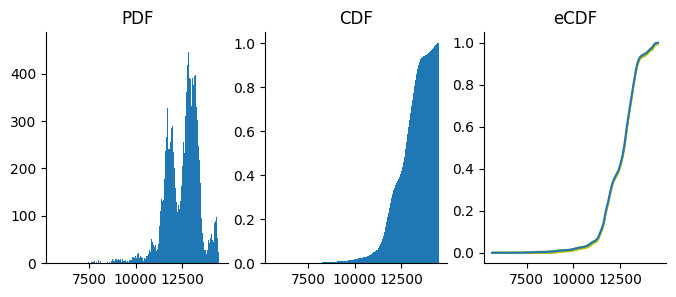

In [18]:
diff_stk = pred_stk - real_stk
diff_stk_norm = st.zscore(diff_stk)

pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=diff_stk, plot=True)

x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=0.95)
print(x)


-76.04483756894845


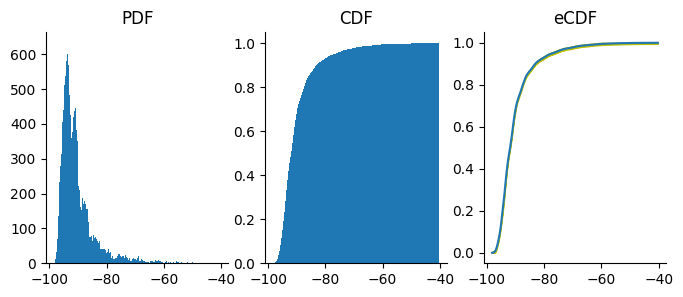

In [19]:
# divide by pred to know how much increase pred to reach real
# i.e. pred + pred * perc = real
# underestimation is with positive sign (how much perc add to meet the real traffic)

perc_stk = (real_stk - pred_stk) / pred_stk * 100
perc_stk_half = perc_stk[perc_stk > 0].reset_index(drop=True)

pdf, cdf, ecdf, ecdf_lower, ecdf_upper, bins = get_distributions(df=perc_stk, plot=True)

x, y, x_l, x_r, *_ = get_x_for_y(yx_data=ecdf_lower, y=0.95)
print(x)


In [20]:
if RESET_SEED: init_random();
res = st.kstest(diff_stk_norm.sample(n=500), 'norm')
res.pvalue

0.004287676280672143

In [21]:
if RESET_SEED: init_random();
res = st.shapiro(diff_stk_norm.sample(n=50))
print(res.pvalue)

0.017170602455735207


In [22]:
# get stats

print('mean: ' + str(diff_stk.mean()))
print('std: ' + str(diff_stk.std()))

se = diff_stk.std() / math.sqrt(len(diff_stk)) # standard error st.sem(diff_stk)
print('se: ' + str(se))

t_interval = st.t.interval(confidence=0.95, df=len(diff_stk) - 1, loc=diff_stk.mean(), scale=se)
norm_interval = st.norm.interval(confidence=0.95, loc=diff_stk.mean(), scale=se)

print('t_interval: ' + str(t_interval))
print('norm_interval: ' + str(norm_interval))

mean: 12505.493561914724
std: 938.447223237157
se: 3.4834801437726215
t_interval: (12498.6659524251, 12512.321171404346)
norm_interval: (12498.66606629207, 12512.321057537378)


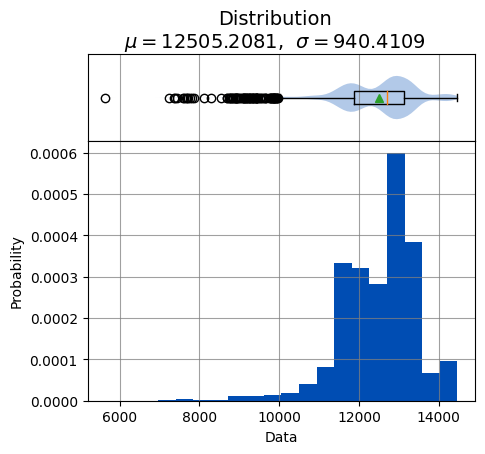



Statistics
----------

n         =  5000
Mean      =  12505.2081
Std Dev   =  940.4109
Std Error =  13.2994
Skewness  = -1.0478
Kurtosis  =  3.1596
Maximum   =  14464.9805
75%       =  13130.4311
50%       =  12712.5963
25%       =  11876.0589
Minimum   =  5638.6239
IQR       =  1254.3722
Range     =  8826.3566


Shapiro-Wilk test for normality
-------------------------------

alpha   =  0.0500
W value =  0.9405
p value =  0.0000

HA: Data is not normally distributed



In [23]:
if RESET_SEED: init_random();
analyze(xdata=diff_stk.sample(n=5000))